## Variational Inference

The dataset required is small and is available preprocessed here:

- https://drive.google.com/drive/folders/1Tg_3SlKbdv0pDog6k2ys0J79e1-vgRyd?usp=sharing

In [1]:
import torch
import numpy as np
from gpytorch.optim import NGD
from torch.optim import Adam
from torch.nn import Parameter
from matplotlib import pyplot as plt
from os import path

from lafomo.datasets import P53Data
from lafomo.configuration import VariationalConfiguration
from lafomo.models import OrdinaryLFM, MultiOutputGP
from lafomo.plot import Plotter
from lafomo.trainers import VariationalTrainer
from lafomo.utilities.data import p53_ground_truth

Let's start by importing our dataset...

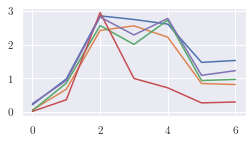

In [2]:
dataset = P53Data(replicate=0, data_dir='../../../data')
num_genes = 5
num_tfs = 1

plt.figure(figsize=(4, 2))
for i in range(5):
    plt.plot(dataset[i][1])

Differential equation here: ....

Since this is an ordinary differential equation (ODE), we inherit from the `OrdinaryLFM` class.

In [3]:
class TranscriptionLFM(OrdinaryLFM):
    def __init__(self, num_outputs, gp_model, config: VariationalConfiguration):
        super().__init__(num_outputs, gp_model, config)
        self.decay_rate = Parameter(0.1 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))
        self.basal_rate = Parameter(torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))
        self.sensitivity = Parameter(0.2 + torch.rand(torch.Size([self.num_outputs, 1]), dtype=torch.float64))

    def initial_state(self):
        return self.basal_rate / self.decay_rate

    def odefunc(self, t, h):
        """h is of shape (num_samples, num_outputs, 1)"""
        self.nfe += 1
        # if (self.nfe % 100) == 0:
        #     print(t)

        decay = self.decay_rate * h

        f = self.f[:, :, self.t_index].unsqueeze(2)

        h = self.basal_rate + self.sensitivity * f - decay
        if t > self.last_t:
            self.t_index += 1
        self.last_t = t
        return h

In [4]:
config = VariationalConfiguration(
    preprocessing_variance=dataset.variance,
    num_samples=80,
    kernel_scale=False,
    initial_conditions=False
)

num_inducing = 12  # (I x m x 1)
inducing_points = torch.linspace(0, 12, num_inducing).repeat(num_tfs, 1).view(num_tfs, num_inducing, 1)
t_predict = torch.linspace(-1, 13, 80, dtype=torch.float32)
step_size = 1e-1

gp_model = MultiOutputGP(inducing_points, num_tfs)
lfm = TranscriptionLFM(num_genes, gp_model, config)
plotter = Plotter(lfm, dataset.gene_names, style='seaborn')

In [5]:
variational_keys = dict(lfm.gp_model.named_variational_parameters()).keys()
named_parameters = dict(lfm.named_parameters())
print(named_parameters.keys())
parameters = [named_parameters[key] for key in named_parameters.keys()
              if key[len('gp_model.'):] not in variational_keys]
print(parameters)

dict_keys(['decay_rate', 'basal_rate', 'sensitivity', 'gp_model.variational_strategy.base_variational_strategy._variational_distribution.natural_vec', 'gp_model.variational_strategy.base_variational_strategy._variational_distribution.natural_mat', 'gp_model.covar_module.raw_lengthscale', 'likelihood.raw_task_noises', 'likelihood.raw_noise'])
[Parameter containing:
tensor([[0.2974],
        [0.5577],
        [1.0252],
        [0.7935],
        [0.7485]], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([[0.6833],
        [0.6670],
        [0.9978],
        [0.4946],
        [0.9495]], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([[0.4988],
        [0.2879],
        [0.4827],
        [0.6450],
        [0.2644]], dtype=torch.float64, requires_grad=True), Parameter containing:
tensor([[[0.]]], requires_grad=True), Parameter containing:
tensor([0., 0., 0., 0., 0.], requires_grad=True), Parameter containing:
tensor([0.], requires_grad=True)]
to

In [6]:
class P53ConstrainedTrainer(VariationalTrainer):
    def after_epoch(self):
        super().after_epoch()
        # self.cholS.append(self.lfm.q_cholS.detach().clone())
        # self.mus.append(self.lfm.q_m.detach().clone())
        with torch.no_grad():
            # TODO can we replace these with parameter transforms like we did with lengthscale
            # self.lfm.sensitivity.clamp_(0, 20)
            self.lfm.basal_rate.clamp_(0, 20)
            self.lfm.decay_rate.clamp_(0, 20)
            self.lfm.sensitivity[3] = np.float64(1.)
            self.lfm.decay_rate[3] = np.float64(0.8)

track_parameters = [
    'basal_rate',
    'decay_rate',
    'sensitivity',
    'gp_model.covar_module.raw_lengthscale',
]
num_training = dataset.m_observed.shape[-1]
variational_optimizer = NGD(lfm.variational_parameters(), num_data=num_training, lr=0.1)
parameter_optimizer = Adam(lfm.nonvariational_parameters(), lr=0.03)
optimizers = [variational_optimizer, parameter_optimizer]
trainer = P53ConstrainedTrainer(lfm, optimizers, dataset, track_parameters=track_parameters)

### Outputs prior to training:

5
1


NameError: name 'mean' is not defined

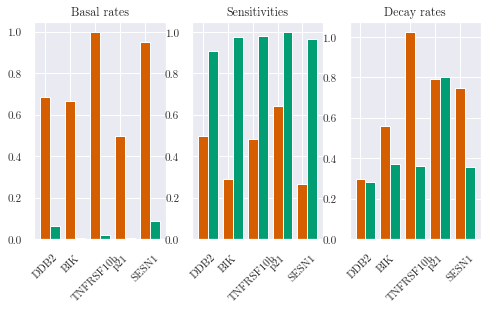

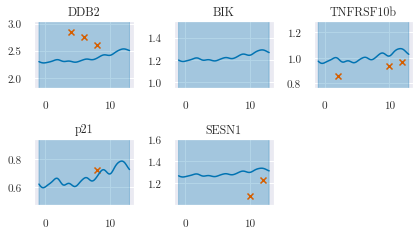

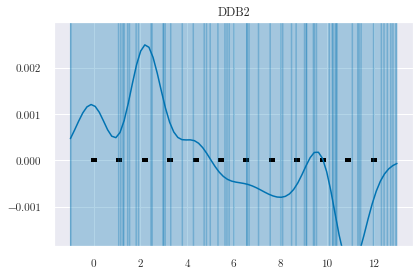

In [9]:
labels = ['Basal rates', 'Sensitivities', 'Decay rates']
kinetics = list()
for key in ['basal_rate', 'sensitivity', 'decay_rate']:
    kinetics.append(trainer.parameter_trace[key][-1].squeeze().numpy())

plotter.plot_double_bar(kinetics, labels, p53_ground_truth())
plotter.plot_outputs(t_predict, replicate=0,
                     t_scatter=dataset.t_observed, y_scatter=dataset.m_observed,
                     model_kwargs=dict(step_size=step_size))
plotter.plot_latents(t_predict, ylim=(-1, 3), plot_barenco=False, plot_inducing=False)


In [10]:
lfm.train()

trainer.train(400, report_interval=10, step_size=step_size)


Epoch 001/400 - Loss: 7.54 (7.54 0.00) kernel: [[[0.6782597]]]
Epoch 011/400 - Loss: 6.55 (6.43 0.12) kernel: [[[0.5907998]]]
Epoch 021/400 - Loss: 5.95 (5.69 0.26) kernel: [[[0.6394874]]]
Epoch 031/400 - Loss: 5.27 (4.86 0.41) kernel: [[[0.74139494]]]
Epoch 041/400 - Loss: 4.60 (4.07 0.53) kernel: [[[0.773257]]]
Epoch 051/400 - Loss: 4.03 (3.39 0.64) kernel: [[[0.8075495]]]
Epoch 061/400 - Loss: 3.38 (2.64 0.74) kernel: [[[0.8316609]]]
Epoch 071/400 - Loss: 2.63 (1.79 0.84) kernel: [[[0.78053695]]]
Epoch 081/400 - Loss: 2.08 (1.14 0.94) kernel: [[[0.77958846]]]
Epoch 091/400 - Loss: 1.56 (0.53 1.03) kernel: [[[0.80998]]]
Epoch 101/400 - Loss: 1.16 (0.04 1.12) kernel: [[[0.82279783]]]
Epoch 111/400 - Loss: 0.77 (-0.44 1.21) kernel: [[[0.84271705]]]
Epoch 121/400 - Loss: 0.51 (-0.77 1.28) kernel: [[[0.85642385]]]
Epoch 131/400 - Loss: 0.36 (-0.98 1.34) kernel: [[[0.8674047]]]
Epoch 141/400 - Loss: 0.45 (-0.95 1.40) kernel: [[[0.88231766]]]
Epoch 151/400 - Loss: 0.14 (-1.30 1.44) kernel:

5
1


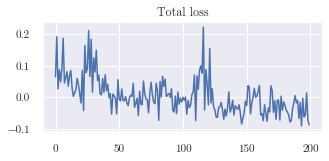

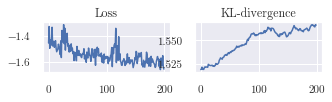

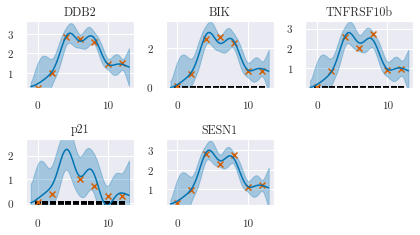

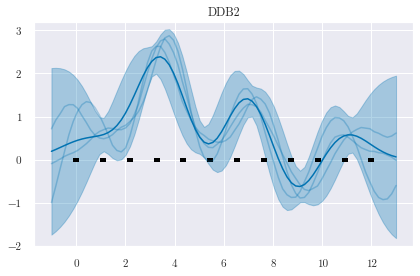

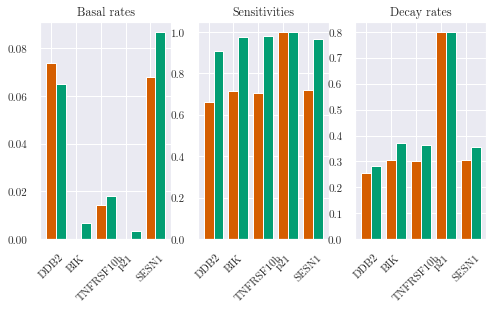

In [12]:
root_dir = '../../../'

lfm.eval()
plotter.plot_losses(trainer, last_x=200)
plotter.plot_outputs(t_predict, replicate=0,
                     t_scatter=dataset.t_observed, y_scatter=dataset.m_observed,
                     model_kwargs=dict(step_size=step_size))

plotter.plot_latents(t_predict, ylim=(-2, 3.2), plot_barenco=False, plot_inducing=False, num_samples=3)

labels = ['Basal rates', 'Decay rates', 'Sensitivities']
keys = ['basal_rate', 'decay_rate', 'sensitivity']
labels = ['Basal rates', 'Sensitivities', 'Decay rates']
kinetics = list()
for key in ['basal_rate', 'sensitivity', 'decay_rate']:
    kinetics.append(trainer.parameter_trace[key][-1].squeeze().numpy())

plotter.plot_double_bar(kinetics, labels, p53_ground_truth())